### Graph Search Algorithms

These algorithms are used to identify optimal routes through a graph for uses such as logistics planning, least cost call or IP routing, and gaming simulation.
Specifically, the pathfinding algorithms we’ll cover are:

* **Shortest Path**, with two useful variations (A* and Yen’s): finding the shortest path or paths between two chosen nodes
* **All Pairs Shortest Path and Single Source Shortest Path**: for finding the shortest paths between all pairs or from a chosen node to all others
* **Minimum Spanning Tree**: for finding a connected tree structure with the smallest cost for visiting all nodes from a chosen node
* **Random Walk:** because it’s a useful preprocessing/sampling step for machine learning workflows and other graph algorithms

For simplicity we consider the graph to be undirected because most roads between cities are bidirectional. We’d get slightly different results if we evaluated the graph as directed because of the small number of one-way streets, but the overall approach remains similar. 

However, Spark operate on directed graphs. In cases like this where we want to work with undirected graphs (e.g., bidirectional roads), there is an easy way to accomplish that:

* We’ll create two relationships for each row in transport- relationships.csv—one going from dst to src and one from src to dst.



In [1]:
import os
#os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.6.0-spark2.3-s_2.11 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.7.0-spark2.3-s_2.11 pyspark-shell'
#os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.8.0-spark3.0-s_2.12 pyspark-shell'

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import udf
import matplotlib.pyplot as plt

In [2]:
sc = pyspark.SparkContext("local[*]")
spark = SparkSession.builder.appName('notebook').getOrCreate()

In [3]:
from graphframes import *
import hashlib
from pyspark.sql.types import * 

In [27]:
def PlotGraph_v2(edge_list):
    Gplot=nx.Graph()
    for row in edge_list.select('src','dst').take(1000):
        Gplot.add_edge(row['src'],row['dst'])

    plt.subplot(121)
    pos = nx.spring_layout(Gplot, k=0.1)
    
    betCent = nx.betweenness_centrality(Gplot, normalized=True, endpoints=True)
    node_color = [20000.0 * Gplot.degree(v) for v in Gplot]
    node_size =  [v * 10000 for v in betCent.values()]
    nx.draw(Gplot, pos, with_labels=True, font_weight='bold',  
            node_size=6600, 
            node_color='#A0CBE2')
    limits=plt.axis('off') # turn of axis
    
    
#nx.draw_networkx(G, pos = pos, with_labels=False, 
#                 node_size=15, width=0.3, node_color='blue', edge_color='grey')


In [7]:
from pyspark.sql.types import * 
from graphframes import *

In [20]:
def create_transport_graph(): 
    node_fields = [
            StructField("id", StringType(), True),
            StructField("latitude", FloatType(), True),
            StructField("longitude", FloatType(), True),
            StructField("population", IntegerType(), True)
    ]
    nodes = spark.read.csv("data/transport-nodes.csv", header=True,
                           schema=StructType(node_fields))
    rels = spark.read.csv("data/transport-relationships.csv", header=True)
    #src:source/dst:destiny
    reversed_rels = (rels.withColumn("newSrc", rels.dst)
    .withColumn("newDst", rels.src)
    .drop("dst", "src") .withColumnRenamed("newSrc", "src") .withColumnRenamed("newDst", "dst") .select("src", "dst", "relationship", "cost"))
    relationships = rels.union(reversed_rels) 
    return GraphFrame(nodes, relationships)

In [22]:
g = create_transport_graph()

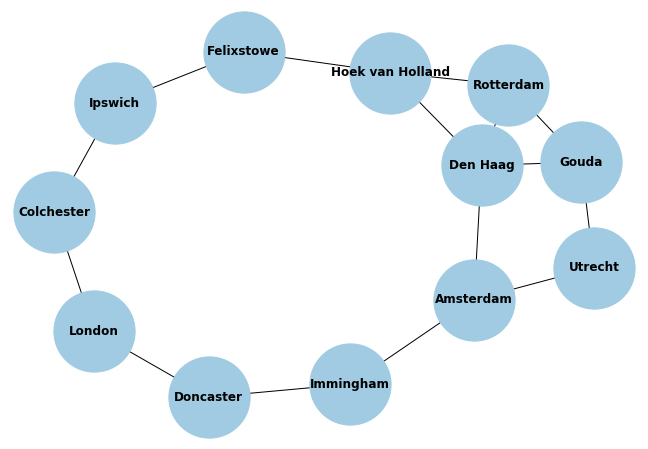

In [40]:
plt.figure(figsize=(25, 8))
import matplotlib.pyplot as plt
import networkx as nx
PlotGraph_v2(g.edges)

In [42]:
g.vertices.show()

+----------------+---------+---------+----------+
|              id| latitude|longitude|population|
+----------------+---------+---------+----------+
|       Amsterdam| 52.37919| 4.899431|    821752|
|         Utrecht|52.092876|  5.10448|    334176|
|        Den Haag|52.078663| 4.288788|    514861|
|       Immingham| 53.61239| -0.22219|      9642|
|       Doncaster| 53.52285| -1.13116|    302400|
|Hoek van Holland|  51.9775|  4.13333|      9382|
|      Felixstowe| 51.96375|   1.3511|     23689|
|         Ipswich| 52.05917|  1.15545|    133384|
|      Colchester| 51.88921|  0.90421|    104390|
|          London|51.509865|-0.118092|   8787892|
|       Rotterdam|  51.9225|  4.47917|    623652|
|           Gouda| 52.01667|  4.70833|     70939|
+----------------+---------+---------+----------+



In [44]:
g.edges.show()

+----------------+----------------+------------+----+
|             src|             dst|relationship|cost|
+----------------+----------------+------------+----+
|       Amsterdam|         Utrecht|       EROAD|  46|
|       Amsterdam|        Den Haag|       EROAD|  59|
|        Den Haag|       Rotterdam|       EROAD|  26|
|       Amsterdam|       Immingham|       EROAD| 369|
|       Immingham|       Doncaster|       EROAD|  74|
|       Doncaster|          London|       EROAD| 277|
|Hoek van Holland|        Den Haag|       EROAD|  27|
|      Felixstowe|Hoek van Holland|       EROAD| 207|
|         Ipswich|      Felixstowe|       EROAD|  22|
|      Colchester|         Ipswich|       EROAD|  32|
|          London|      Colchester|       EROAD| 106|
|           Gouda|       Rotterdam|       EROAD|  25|
|           Gouda|         Utrecht|       EROAD|  35|
|        Den Haag|           Gouda|       EROAD|  32|
|Hoek van Holland|       Rotterdam|       EROAD|  33|
|         Utrecht|       Ams

### **Breadth First Search**

Breadth First Search (BFS) is one of the fundamental graph traversal algorithms. It starts from a chosen node and explores all of its neighbors at one hop away before visiting all the neighbors at two hops away, and so on.

BFS is most commonly used as the basis for other more goal-oriented algorithms. For example, 
* Shortest Path, 
* Connected Components, and 
* Closeness Centrality 

all use the BFS algorithm. 

It can also be used to find the shortest path between nodes.

## **Problem:**

Find the first medium-sized city that has a population of between 100,000 and 300,000 people.

**Solution:** The BFS algorithm should find any route to the following cities, starting from **Den Haag**

In [30]:
(g.vertices
.filter("population > 100000 and population < 300000") .sort("population")
.show())

+----------+--------+---------+----------+
|        id|latitude|longitude|population|
+----------+--------+---------+----------+
|Colchester|51.88921|  0.90421|    104390|
|   Ipswich|52.05917|  1.15545|    133384|
+----------+--------+---------+----------+



We apply the **bfs** function:

In [32]:
from_expr = "id='Den Haag'"
to_expr = "population > 100000 and population < 300000 and id <> 'Den Haag'" 
result = g.bfs(from_expr, to_expr)

In [33]:
print(result.columns)

['from', 'e0', 'v1', 'e1', 'v2', 'e2', 'to']


Columns beginning with e represent relationships (edges) and columns beginning with v represent nodes (vertices). We’re only interested in the nodes, so let’s filter out any columns that begin with e from the resulting DataFrame:

In [46]:

columns = [column for column in result.columns if not column.startswith("e")] 
result.select(columns).show(10, False)

+---------------------------------------+------------------------------------------+-------------------------------------+------------------------------------+
|from                                   |v1                                        |v2                                   |to                                  |
+---------------------------------------+------------------------------------------+-------------------------------------+------------------------------------+
|[Den Haag, 52.078663, 4.288788, 514861]|[Hoek van Holland, 51.9775, 4.13333, 9382]|[Felixstowe, 51.96375, 1.3511, 23689]|[Ipswich, 52.05917, 1.15545, 133384]|
+---------------------------------------+------------------------------------------+-------------------------------------+------------------------------------+



As expected, the bfs algorithm returns Ipswich! Remember that this function is satisfied when it finds the first match

**Route:** Den Haag -> Hoek van Holland -> Felixstowe -> Ipswich

#### **Depth First Search**